 GAN = minimax game which G(generator) wants to minimize V while D(Discriminator) wants to maximize it.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from keras import initializers

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# We only concerned with 'X_train' data
# It can be rewritten as (X_train,_),(_,_) = mnist.load_data()

prev = X_train.shape

11493376/11490434 [==============================] - 1s 0us/step


In [4]:
X_train = X_train.reshape(60000, 28*28)

print(prev)
print(X_train.shape)

(60000, 28, 28)
(60000, 784)


In [5]:
# normalizing the inputs (-1, 1)

X_train = (X_train.astype('float32') / 255 - 0.5) * 2
# we have pixels from 0-255, dividing by 255 leads to normalize them in range 0-1
#(-0.5) * 2 shift it to (-1,1) for tanh activation

The first model is called a Generator and it aims to generate new data similar to the expected one.

## Generator

**Generator try to fool by generating real-looking images**

* Input to the generator is a series of randomly generated numbers called latent sample. 
* It tries to produce data that come from some probability distribution. 
* The generator network takes random noise as input, then runs that noise through a differentiable function to transform the noise and reshape it to have recognizable structure. 
* The output of the generator network ia a realistic image. Without training, the generator produces garbage images only.

In [6]:
latent_dim = 100
# Latent dimensions are dimensions which we do not directly observe, but which we assume to exist (Hidden)
# We use this in reference of generator, it create images from latent dimension whichwe  do not directly observe, but assume to exist

# image dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)
# stddev = Standard deviation of the random values to generate

# The neural network needs to start with some weights and then iteratively update them to better values. 
# kernel_initializer is term for which statistical distribution or function to use for initialising the weights.
# Ref - https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance

# Generator network

# sequential model simply allows us to stitch layers together
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# A dense layer is simply a fully connected layer of neurons.

# The LeakyReLU remove problem of "dying ReLU" and alpha is negative slope constant
# Deep dive - https://towardsdatascience.com/complete-guide-of-activation-functions-34076e95d044

# batchnormalization layer will transform inputs so they will have a mean of zero and a standard deviation of one.
# “momentum” in batch norm allows you to control how much of the statistics from the previous mini batch to include when the update is calculated
# Deep dive - https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
__________

## Descriminator

**Discriminator try to distinguish between real and fake images**

* Discriminator is a classifier trained using the supervised learning. 
* It classifies whether an image is real (1) or is fake (0).

In [8]:
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(512, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(128))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

In [9]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total para

In [10]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Since we have to predict either fake or real (i.e. two classes)

* we use both generaor and discriminator model here
* Sets its trainability to False, meaning that during the adversarial training, it will not be training
* Reason behind set trainable=False, Generator is consistently getting better, but discriminator will remain the same.

In [11]:
discriminator.trainable = False

d_g = Sequential()
d_g.add(generator)
d_g.add(discriminator)
d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### Workflow

1) Set the discriminator trainable

2) Train the discriminator with the real MNIST digit images and the images generated by the generator to classify the real and fake images.

3) Set the discriminator non-trainable

4) Train the generator as part of the GAN. We feed latent samples into the GAN and let the generator to produce digit images and use the discriminator to classify the image

In [12]:
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 784)               583312    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 566273    
Total params: 1,149,585
Trainable params: 581,520
Non-trainable params: 568,065
_________________________________________________________________


In [13]:
epochs = 100
batch_size = 64

#### Basic Idea

* When we feed a latent sample to the GAN, the generator internally produces a digit image which is then passed to the discriminator for classification. If the generator does a good job, the discriminator returns a value close to 1
* However, the generator initially produces garbage images, and the loss value is high. So, the back-propagation updates the generator’s weights to produce more realistic images as the training continues. 

In [14]:
real = np.ones(shape=(batch_size, 1)) #craete a "real" array with values = 1 and size = 100 
fake = np.zeros(shape=(batch_size, 1)) # craete a "fake" array with values = 0 and size = 100

In [15]:
d_loss = [] #discriminator loss
d_g_loss = [] #adversarial loss/generator loss

## Training

It's like Two player game: The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

Instructions for updating:
Use tf.cast instead.
epoch = 1/100, d_loss=0.611, g_loss=1.832                                                                                                     


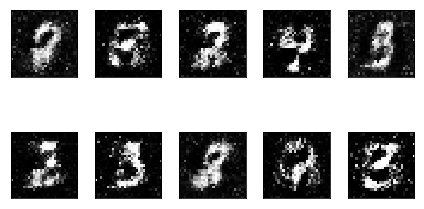

epoch = 2/100, d_loss=0.584, g_loss=1.849                                                                                                     
epoch = 3/100, d_loss=0.460, g_loss=1.872                                                                                                     
epoch = 4/100, d_loss=0.517, g_loss=1.623                                                                                                     
epoch = 5/100, d_loss=0.426, g_loss=1.965                                                                                                     
epoch = 6/100, d_loss=0.447, g_loss=1.783                                                                                                     
epoch = 7/100, d_loss=0.499, g_loss=1.824                                                                                                     
epoch = 8/100, d_loss=0.451, g_loss=1.763                                                                                                     

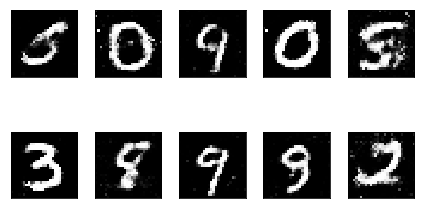

epoch = 12/100, d_loss=0.570, g_loss=1.568                                                                                                     
epoch = 13/100, d_loss=0.487, g_loss=1.544                                                                                                     
epoch = 14/100, d_loss=0.494, g_loss=1.653                                                                                                     
epoch = 15/100, d_loss=0.486, g_loss=1.543                                                                                                     
epoch = 16/100, d_loss=0.468, g_loss=1.521                                                                                                     
epoch = 17/100, d_loss=0.477, g_loss=1.710                                                                                                     
epoch = 18/100, d_loss=0.531, g_loss=1.475                                                                                              

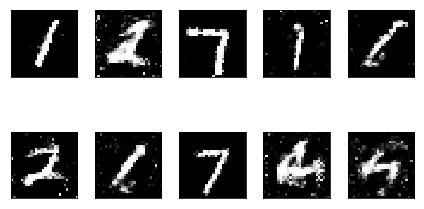

epoch = 22/100, d_loss=0.459, g_loss=1.746                                                                                                     
epoch = 23/100, d_loss=0.456, g_loss=1.789                                                                                                     
epoch = 24/100, d_loss=0.471, g_loss=1.651                                                                                                     
epoch = 25/100, d_loss=0.425, g_loss=1.726                                                                                                     
epoch = 26/100, d_loss=0.534, g_loss=1.422                                                                                                     
epoch = 27/100, d_loss=0.466, g_loss=1.545                                                                                                     
epoch = 28/100, d_loss=0.442, g_loss=1.718                                                                                              

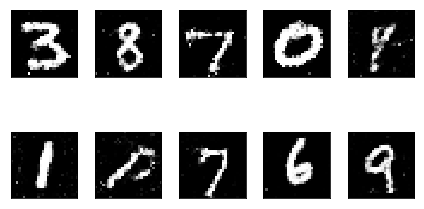

epoch = 32/100, d_loss=0.476, g_loss=1.622                                                                                                     
epoch = 33/100, d_loss=0.452, g_loss=1.735                                                                                                     
epoch = 34/100, d_loss=0.489, g_loss=1.665                                                                                                     
epoch = 35/100, d_loss=0.566, g_loss=1.538                                                                                                     
epoch = 36/100, d_loss=0.461, g_loss=1.750                                                                                                     
epoch = 37/100, d_loss=0.487, g_loss=1.601                                                                                                     
epoch = 38/100, d_loss=0.450, g_loss=1.736                                                                                              

In [16]:
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
                
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        # Defining size of batches per 64 in one batch
        
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (0.9))
        # train_on_batch (predefined keras function) - Runs a single gradient update on a single batch of data.
        # Pre train discriminator on  fake and real data  before starting the gan.
        # helps to check if our compiled models run fine on our real data as well as the noised data.
        
       
        # Fake Samples      
                
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        # generate random noise as an input to initialize generator
        
        X_fake = generator.predict_on_batch(z)
        # Generate fake MNIST images from noised input
        
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        # train discriminator on fake images generated by generator and fake data (array of 0 values)
         
        # Discriminator loss.... well what's this ?
        # we only grabbed half the number of images that we specified with the real loss, 
        # we're take other half images from our generator for the other half of the batch:

        
        
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        
        discriminator.trainable = False
        # When we train the GAN we need to freeze the weights of the Discriminator. 
        # GAN is trained by alternating training of Discriminator and then training chained GAN model with Discriminator weights frozen
        
        # during training of gan weights of discriminator should be fixed We can enforce that by setting the trainable flag
        
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)
        # training the GAN by alternating training of Discriminator 
        # training the chained GAN model with Discriminator’s weights freezed
        
        # We'll now train the GAN with mislabeled generator outputs ([z=Noise] with [real i.e. 1]). 
        # That means we will generate images from noise and assign a label to one of them while training with the GAN
        
        # But Why ?
        
        # we are using the newly trained discriminator to improve generated output
        # GAN loss is going to describe the confusion of discriminator from generated outputs.

 # Rest is for visualization   
        print('epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % 
            (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),100*' ',end='\r')
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

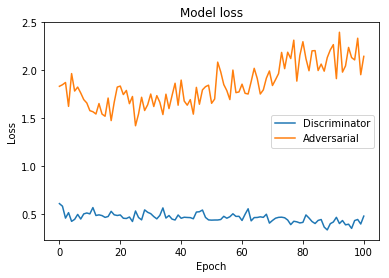

In [17]:
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()